Simulating a Baseball Field

• sportypy – This package (which provides modules like MiLBField) lets you easily draw baseball fields in Python. It’s been used in examples where a baseball field is rendered and animated (see, for example, discussions on Stack Overflow).
• pybaseball – In addition to accessing MLB stats, this library even includes plotting utilities that can overlay data on a baseball field.
Animating Biomechanics

For simulating and animating human motion (for example, a baseball swing), you can consider: • OpenSim (with its Python API) – Widely used in biomechanics research, OpenSim offers tools for modeling musculoskeletal systems and simulating movement, though it’s a bit more involved.
• biorbd – A lighter, open‐source library with Python bindings designed for analyzing and simulating human body biomechanics. It’s well suited for tasks like animating joint kinematics and muscle dynamics.
• Pyomeca or Kinetics Toolkit – These toolkits focus on processing and visualizing motion capture data and can be adapted to animate biomechanical models.

In many cases, you might combine one package for the baseball field (e.g. sportypy) with a biomechanics simulation package (e.g. OpenSim or biorbd) to both render the playing field and animate a player’s motion.

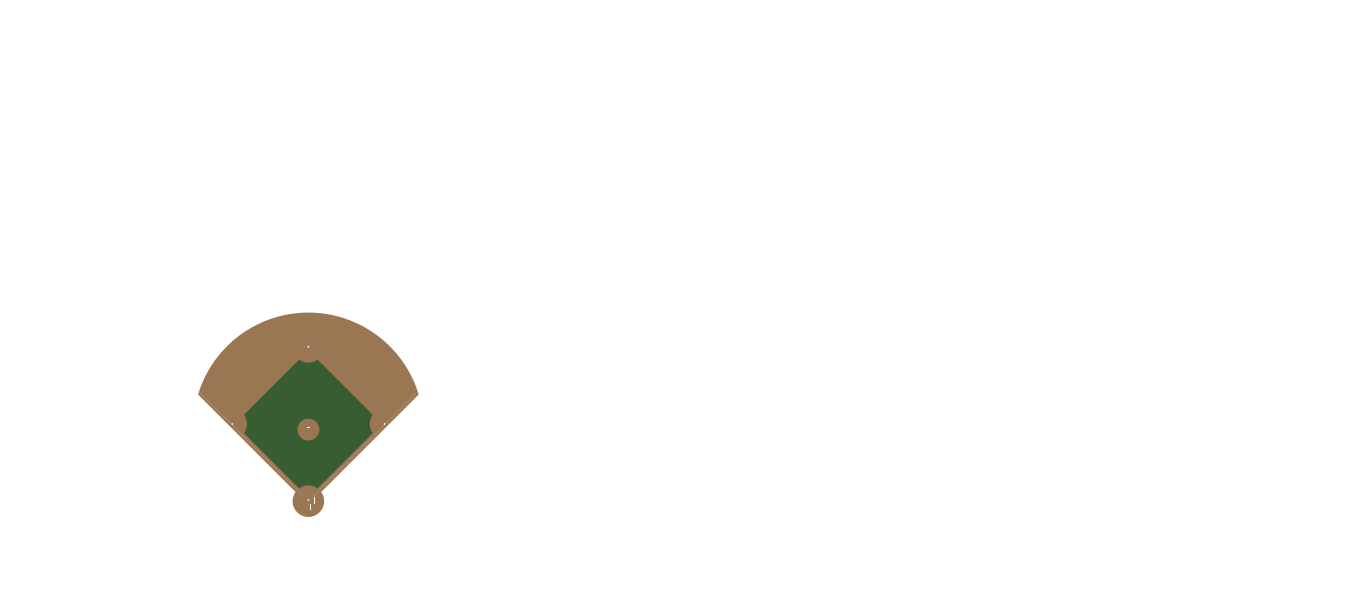

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

# Import the baseball field drawing tool from sportypy.
# (Ensure you have sportypy installed: pip install sportypy)
from sportypy.surfaces import MiLBField

# =============================================================================
# 1. Create a Dummy Biomechanics Dataset for a Baseball Swing
# =============================================================================
# For simplicity, we use a 2D stick figure with 13 joints.
# Joint order (indices):
# 0: Head  
# 1: Left Shoulder  
# 2: Right Shoulder  
# 3: Left Elbow  
# 4: Right Elbow  
# 5: Left Hand  
# 6: Right Hand  
# 7: Left Hip  
# 8: Right Hip  
# 9: Left Knee  
# 10: Right Knee  
# 11: Left Ankle  
# 12: Right Ankle

num_frames = 60  # total frames in the swing animation
num_joints = 13

# We set up a base (static) skeleton pose (in meters) representing a relaxed stance.
base_positions = np.array([
    [0, 1.8],    # Head
    [-0.3, 1.6], # Left Shoulder
    [0.3, 1.6],  # Right Shoulder
    [-0.7, 1.2], # Left Elbow
    [0.7, 1.2],  # Right Elbow
    [-0.9, 0.8], # Left Hand
    [0.9, 0.8],  # Right Hand
    [-0.3, 1.0], # Left Hip
    [0.3, 1.0],  # Right Hip
    [-0.3, 0.5], # Left Knee
    [0.3, 0.5],  # Right Knee
    [-0.3, 0.0], # Left Ankle
    [0.3, 0.0]   # Right Ankle
])

# To simulate a baseball swing, we create time-varying perturbations.
# In this dummy example, the right side (shoulder, elbow, hand) will move in an arc
# to mimic a swing while the rest of the body remains roughly stationary.
time = np.linspace(0, 2*np.pi, num_frames)
biomech_data = np.zeros((num_frames, num_joints, 2))

for f in range(num_frames):
    # Start with the base pose
    frame_pose = base_positions.copy()
    
    # Add a sinusoidal swing motion to the right arm joints (indices 2,4,6)
    # Here the swing amplitude is modulated by sin(time), with the hand moving in an arc.
    swing_offset = 0.5 * np.sin(time[f])
    # Shift the right shoulder (index 2) slightly upward and right
    frame_pose[2] += np.array([swing_offset, swing_offset * 0.5])
    # Elbow (index 4) moves more pronounced in an arc
    frame_pose[4] += np.array([1.0 * np.sin(time[f]), 0.5 * np.cos(time[f])])
    # Hand (index 6) follows the swing with a larger arc (simulate bat acceleration)
    frame_pose[6] += np.array([1.2 * np.sin(time[f]), 0.8 * np.cos(time[f])])
    
    biomech_data[f] = frame_pose

# =============================================================================
# 2. Compute Dummy Metrics for Each Frame
# =============================================================================
# For example, we’ll compute:
# - Head vertical position ("Head_Y")
# - Right hand x-position ("Right_Hand_X")
# - A dummy "swing speed" metric based on the hand displacement

metrics_list = []
for f in range(num_frames):
    head_y = biomech_data[f, 0, 1]
    right_hand_x = biomech_data[f, 6, 0]
    # Here swing speed is computed as the absolute x difference from the base hand position
    swing_speed = abs(biomech_data[f, 6, 0] - base_positions[6, 0])
    metrics_list.append({
        'Frame': f,
        'Head_Y (m)': np.round(head_y, 2),
        'Right_Hand_X (m)': np.round(right_hand_x, 2),
        'Swing_Speed (m)': np.round(swing_speed, 2)
    })

metrics_df = pd.DataFrame(metrics_list)

# =============================================================================
# 3. Set Up the Baseball Field using sportypy (MiLBField)
# =============================================================================
# Create an instance of MiLBField (this draws a realistic baseball field).
field = MiLBField()

# We will later call the field’s draw method to render the field.
# For this example, we assume the field is drawn in 2D with coordinates in meters.
# (sportypy’s MiLBField uses its own coordinate system.)
    
# =============================================================================
# 4. Set Up the Figure and Axes
# =============================================================================
fig = plt.figure(figsize=(14, 6))

# Left subplot: Baseball field with overlaid biomechanics (stick-figure) animation.
ax_field = fig.add_subplot(1, 2, 1)
# Draw the baseball field using sportypy.
# The display_range parameter can be used to set how much of the field is visible.
field.draw(ax=ax_field, display_range='full')

# We want to overlay our stick-figure on the field.
# Depending on the field’s coordinate system, we might need to apply an offset.
# Here, we apply an offset to shift our dummy model to a plausible position on the field.
offset = np.array([15, 20])
    
# Right subplot: Table of metrics.
ax_table = fig.add_subplot(1, 2, 2)
ax_table.axis('off')  # hide axes for table display

# =============================================================================
# 5. Initialize the Stick-Figure Lines (Bones)
# =============================================================================
# Define connectivity for the stick figure (same as before).
bones = [
    (0, 1), (0, 2),    # Head to left/right shoulders
    (1, 3), (2, 4),    # Shoulders to elbows
    (3, 5), (4, 6),    # Elbows to hands
    (1, 7), (2, 8),    # Shoulders to hips
    (7, 9), (8, 10),   # Hips to knees
    (9, 11), (10, 12)  # Knees to ankles
]

# Create line objects for each bone for the initial frame (frame 0).
lines = []
for (i, j) in bones:
    x_coords = [biomech_data[0, i, 0] + offset[0], biomech_data[0, j, 0] + offset[0]]
    y_coords = [biomech_data[0, i, 1] + offset[1], biomech_data[0, j, 1] + offset[1]]
    line, = ax_field.plot(x_coords, y_coords, 'bo-', lw=3)
    lines.append(line)

# =============================================================================
# 6. Define the Animation Update Function
# =============================================================================
def update(frame):
    # --- Update the stick-figure positions ---
    for idx, (i, j) in enumerate(bones):
        x_coords = [biomech_data[frame, i, 0] + offset[0],
                    biomech_data[frame, j, 0] + offset[0]]
        y_coords = [biomech_data[frame, i, 1] + offset[1],
                    biomech_data[frame, j, 1] + offset[1]]
        lines[idx].set_data(x_coords, y_coords)
    
    # --- Update the metrics table on the right ---
    ax_table.clear()
    ax_table.axis('off')
    current_metrics = metrics_df.iloc[[frame]]
    table = ax_table.table(cellText=current_metrics.values,
                           colLabels=current_metrics.columns,
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax_table.set_title(f'Metrics for Frame {frame}', fontsize=12)
    
    return lines

# =============================================================================
# 7. Create and Run the Animation
# =============================================================================
anim = FuncAnimation(fig, update, frames=num_frames, interval=150, blit=False)

plt.tight_layout()
plt.show()
